In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import pickle, time

# pd.set_option("display.max_columns", 100)

In [3]:
df = pd.read_pickle("../../data/total_dataset.pkl") # dataset filtered of peaking background
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1) # signal and background should have the same columns
print("Total dataset number of events: ", len(df))

signal = pd.read_csv("../../data/csv/sig.csv") # as a signal, simulated data is used
print("Number of simulated events: ", len(signal))

bg = pd.read_pickle("../../data/phimumu.pkl")
print("Number of background events: ", len(bg))

# labels for decision trees (0 - background; 1 - signal)
vals = np.concatenate([np.zeros(len(bg)), np.ones(len(signal))])
print("Length of labels array", len(vals))

# (X - independent; Y - dependent) variables for the decision tree classifier
X = bg.append(signal) # concatenation of the two dataframes
X = X.drop(["year", "polarity", "Unnamed: 0"], axis = 1) # dropping columns that have not effect, but may have NaN or other inappropriate data
Y = vals

Total dataset number of events:  498357
Number of simulated events:  8802
Number of background events:  210698
Length of labels array 219500


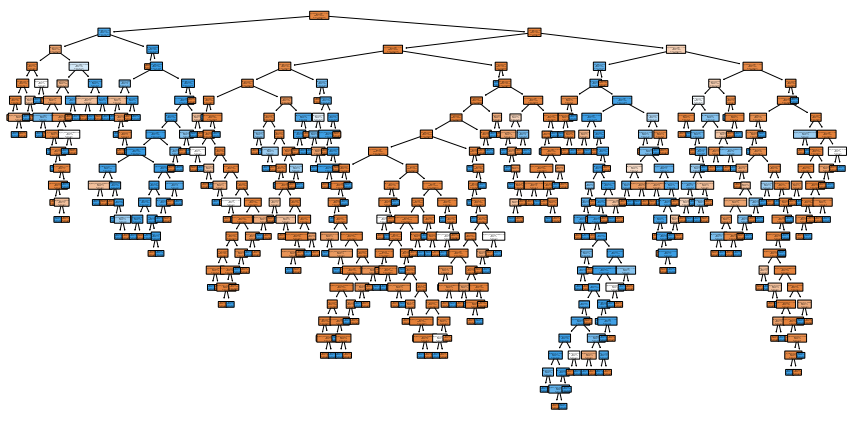

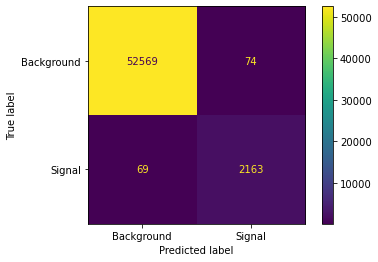

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # splitting data into test and train samples
clf_dt = DecisionTreeClassifier() # creating a Decision Tree
clf_dt = clf_dt.fit(X_train, Y_train) # training it

# Plotting a resulting decision tree
plt.figure(figsize = (15, 7.5))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Plotting a confusion matrix, which will check on the test data false-positive and false-negative identifications
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

<h3>Next section investigates overfitting prevention</h3>

<h3>End of investigation</h3>

In [5]:
path = clf_dt.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # last one should be removed

print(ccp_alphas)
print(len(ccp_alphas))

[0.00000000e+00 4.85822396e-06 5.91865740e-06 5.95452184e-06
 5.98885645e-06 6.00654102e-06 6.01485849e-06 6.01656000e-06
 6.04831622e-06 6.05302277e-06 6.05685544e-06 6.06569020e-06
 6.06790092e-06 6.06804423e-06 6.06919857e-06 6.06954383e-06
 6.07212879e-06 6.07436737e-06 6.07441154e-06 6.07441154e-06
 6.07990816e-06 6.48099054e-06 6.52056496e-06 6.96279720e-06
 8.07408099e-06 8.09921539e-06 8.09921539e-06 8.09921539e-06
 8.09921539e-06 8.09921539e-06 8.09921539e-06 8.09921539e-06
 8.09921539e-06 8.09921539e-06 9.11161731e-06 9.11161731e-06
 9.11161731e-06 9.11161731e-06 9.17313995e-06 9.44721920e-06
 9.55680369e-06 9.71905847e-06 9.71905847e-06 1.00552539e-05
 1.04132769e-05 1.11364212e-05 1.13302690e-05 1.13389015e-05
 1.13389015e-05 1.14341864e-05 1.14528696e-05 1.15094113e-05
 1.15609768e-05 1.15703077e-05 1.17915048e-05 1.18204765e-05
 1.18318973e-05 1.18457689e-05 1.18662923e-05 1.19121389e-05
 1.19318798e-05 1.19559846e-05 1.19800894e-05 1.20015646e-05
 1.20331785e-05 1.204257

Starting alpha num:  0
Execution time for alpha:  120.31772589683533
Starting alpha num:  1
Execution time for alpha:  122.25766706466675
Starting alpha num:  2
Execution time for alpha:  119.43887424468994
Starting alpha num:  3
Execution time for alpha:  119.33974575996399
Starting alpha num:  4
Execution time for alpha:  116.4943437576294
Starting alpha num:  5
Execution time for alpha:  117.57937240600586
Starting alpha num:  6
Execution time for alpha:  116.32486343383789
Starting alpha num:  7
Execution time for alpha:  116.5940432548523
Starting alpha num:  8
Execution time for alpha:  118.40853977203369
Starting alpha num:  9
Execution time for alpha:  116.7262213230133
Starting alpha num:  10
Execution time for alpha:  117.81333518028259
Starting alpha num:  11
Execution time for alpha:  117.12903881072998
Starting alpha num:  12
Execution time for alpha:  116.82699155807495
Starting alpha num:  13
Execution time for alpha:  119.08369994163513
Starting alpha num:  14
Execution

<AxesSubplot:xlabel='alpha'>

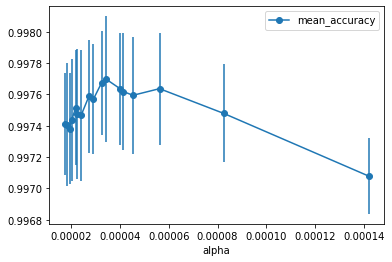

In [7]:
alpha_loop_values = []
# Check different alpha values with cross validation providing errorbars
init_time = time.time()
for num, ccp_alpha in enumerate(ccp_alphas[80:-10:3]): # not all alphas are used to save some time - for better precision all ccp_alphas should be looked at
    print("Starting alpha num: ", num)
    start_time = time.time()
    clf_dt = DecisionTreeClassifier(ccp_alpha = ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, Y_train, cv = 5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    print("Execution time for alpha: ", time.time() - start_time)
print("Total execution time: ", time.time() - init_time)
    
alpha_results = pd.DataFrame(alpha_loop_values, columns = ["alpha", "mean_accuracy", "std"])

alpha_results.plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')

<AxesSubplot:xlabel='alpha'>

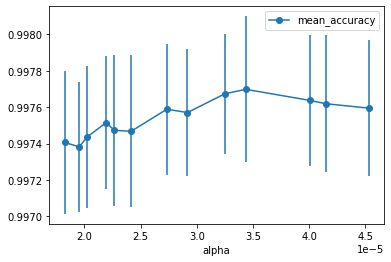

In [8]:
# find the best alpha in terms of absolute accuracy and its error
alpha_results[1:-3].plot(x = 'alpha', y = 'mean_accuracy', yerr = 'std', marker = 'o')


3.4365054320300645e-05


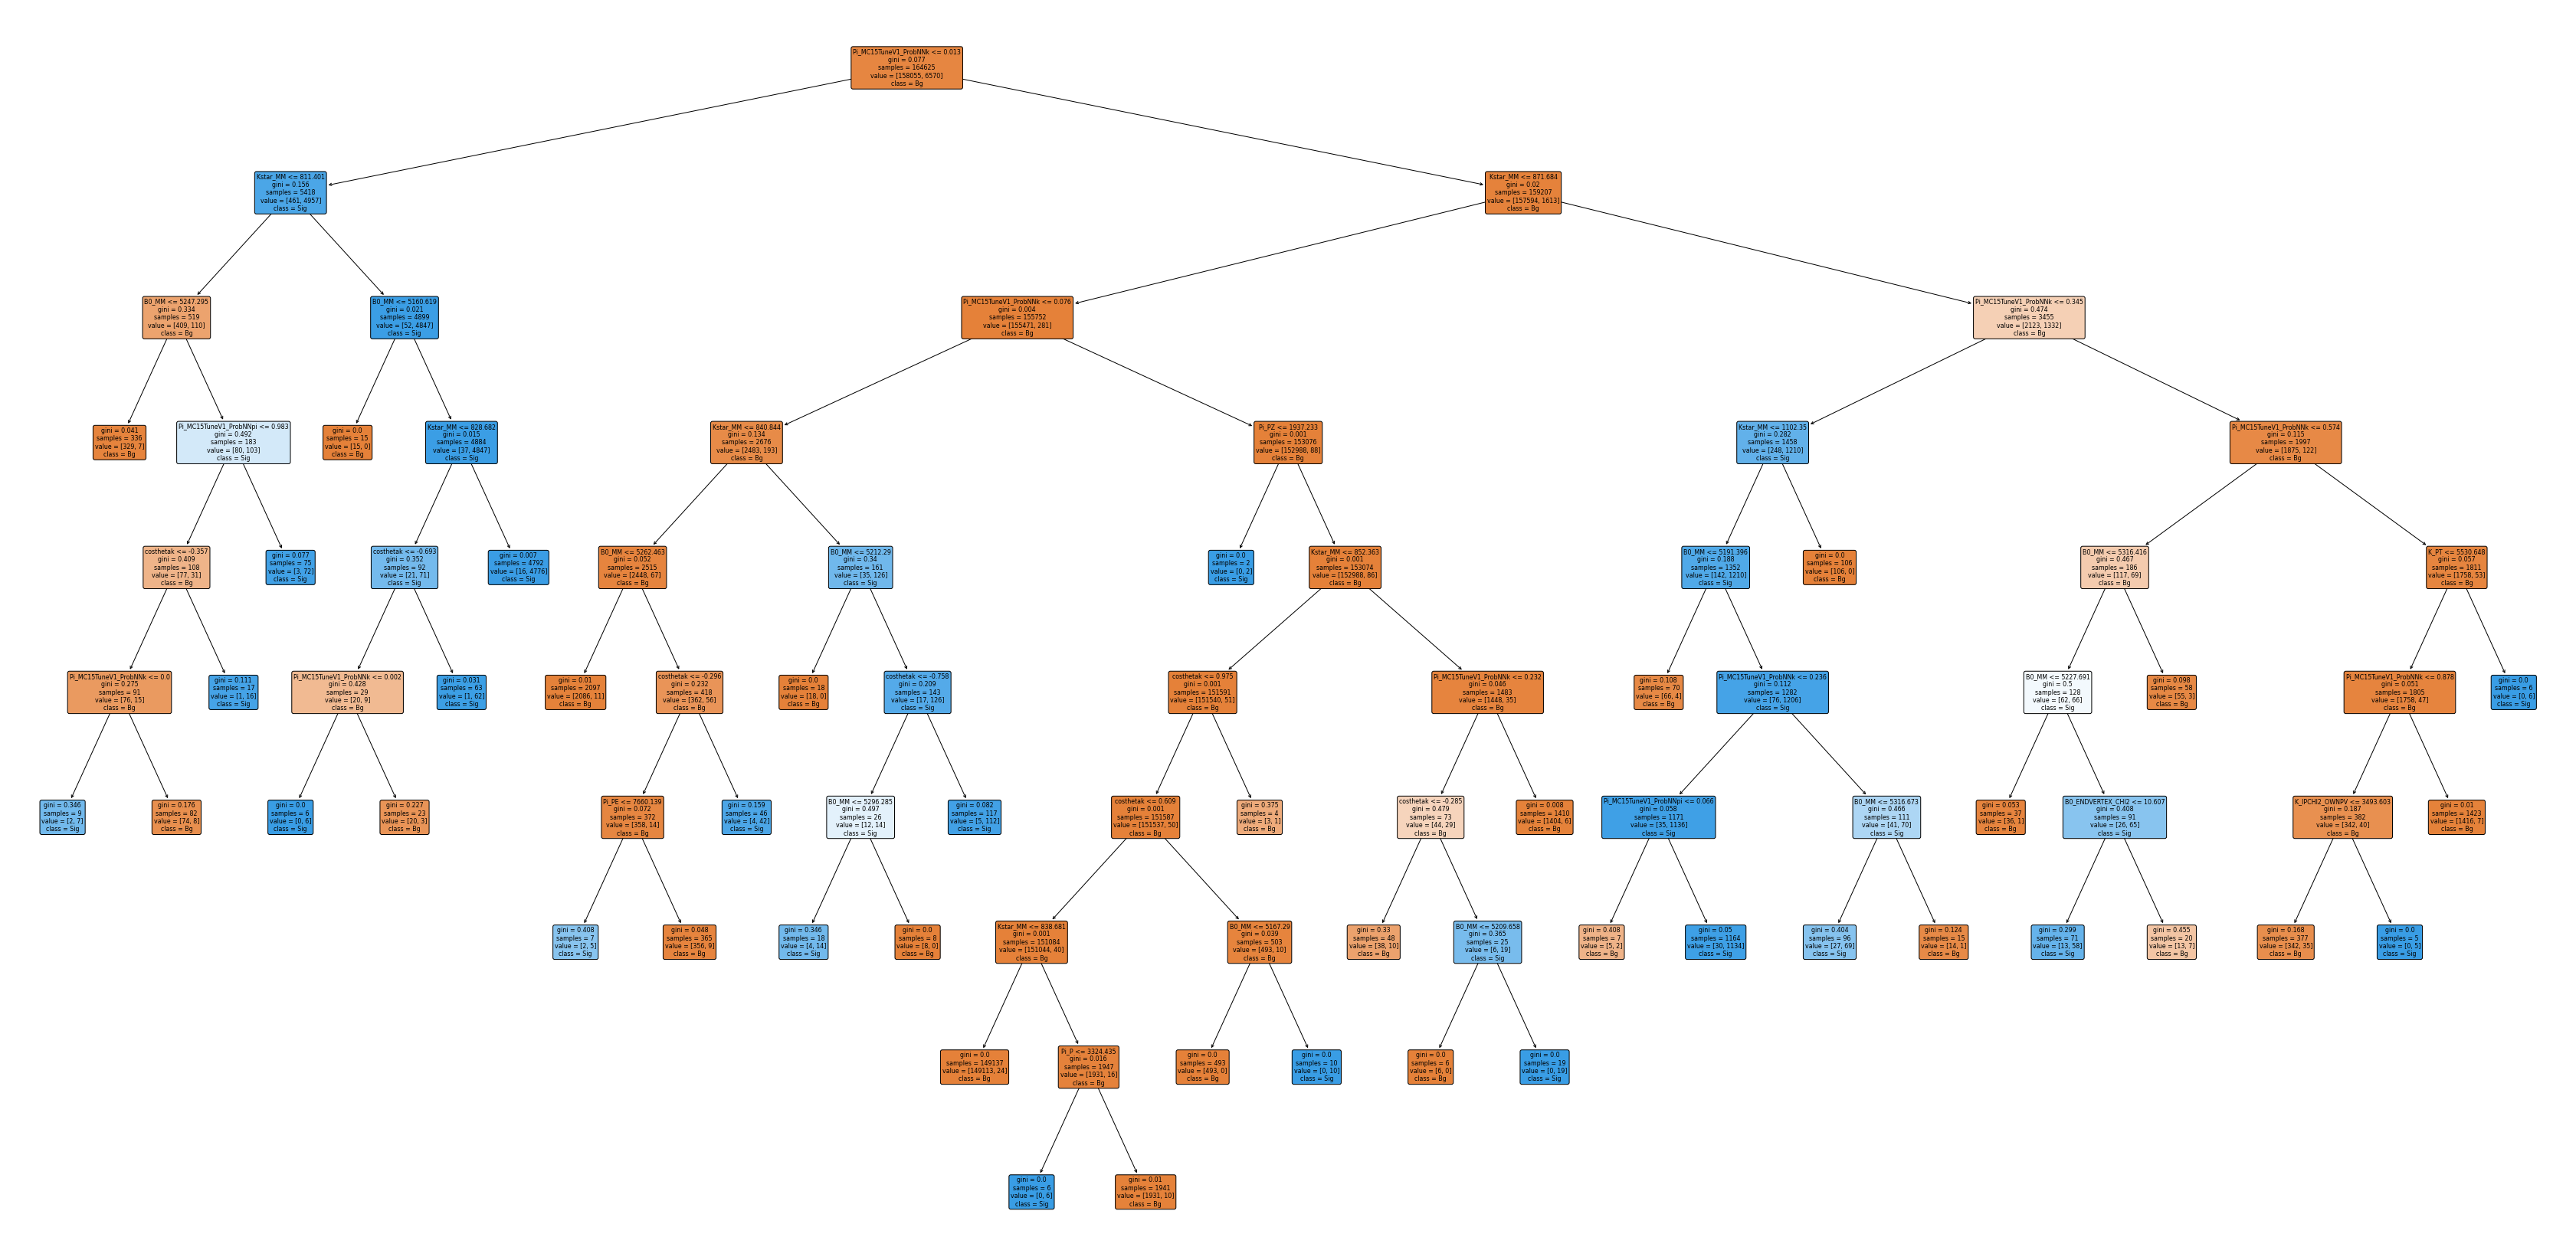

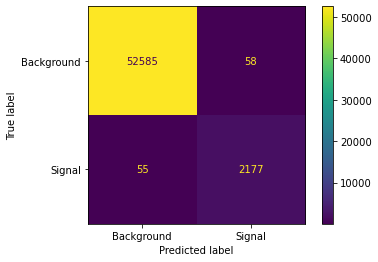

In [9]:
# Extract the best value of alpha
ideal_alpha = ccp_alphas[(ccp_alphas > 0.000034) & (ccp_alphas < 0.000035)][0]
ideal_alpha = float(ideal_alpha)
print(ideal_alpha)

# Resulting decision tree with the ccp_alpha being used to prevent overfitting
clf_dt = DecisionTreeClassifier(ccp_alpha = ideal_alpha)
clf_dt = clf_dt.fit(X_train, Y_train)

plt.figure(figsize = (60, 30))
plot_tree(clf_dt,
         filled = True,
         rounded = True,
         class_names = ["Bg", "Sig"],
         feature_names = X.columns)

# Corresponding confusion matrix
plot_confusion_matrix(clf_dt, X_test, Y_test, display_labels = ["Background", "Signal"])

In [11]:
with open("tree_phimumu", 'wb') as f: # exporting decision tree to 'tree_phimumu' binary file
    pickle.dump(clf_dt, f)

Number of bg (0) and signal (1) events identified (array([0., 1.]), array([110702, 387655], dtype=int64))


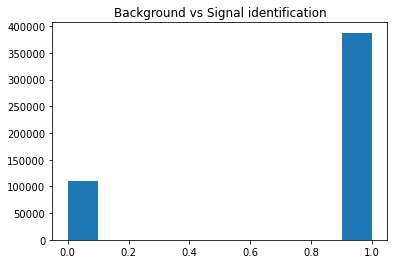

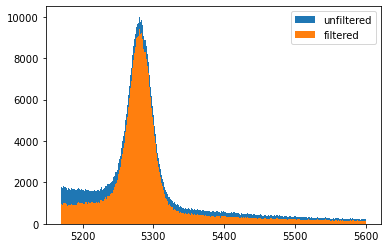

In [12]:
df = pd.read_pickle("../../data/total_dataset.pkl")
#df = df.drop(["accept_kaon", "accept_muon", "accept_pion", "dilepton_mass"], axis = 1)
#print("Total number of events:", len(df))
#total_data = df[(df["B0_MM"] > min_mass) & (df["B0_MM"] < max_mass)].drop(["year", "polarity", "Unnamed: 0"], axis = 1)
#print("Number of events in the mass region", len(total_data))

# Passing data to decision tree
result = clf_dt.predict(df.drop(["year", "polarity"], axis = 1))

print("Number of bg (0) and signal (1) events identified", np.unique(result, return_counts = True))
plt.title("Background vs Signal identification")
plt.hist(result)
plt.show()

# Extracting signal data to 'Filtered_data.pkl'
df["Result"] = result
filtered = df[df["Result"] == 1]
filtered.to_pickle("Filtered_data.pkl")

# Histogram of the filtered data
plt.hist(df['B0_MM'], range=[5170, 5600], bins=300, zorder=1, label = "unfiltered")
plt.hist(filtered['B0_MM'], range=[5170, 5600], bins=300, zorder=2, label = "filtered")
plt.legend()
plt.show()